# Portfolio Report - Booking Revenue Analytics

This is a read-only report built from the primary booking pipeline outputs.
Goal: let a reviewer understand the problem, method, and trustworthiness in ~3 minutes.


## Contract (Notebook <-> Pipeline)

This notebook only reads:
- outputs/booking/tables/metrics.csv
- outputs/booking/tables/metrics_robust.csv (optional)
- outputs/booking/figures/*.png

If any required files are missing, run:
`python pipelines/run_booking.py`


In [1]:
from pathlib import Path


def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists():
            return p
    return start


REPO_ROOT = find_repo_root(Path.cwd())
OUT_DIR = REPO_ROOT / "outputs" / "booking"
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"

metrics_path = TAB_DIR / "metrics.csv"
robust_path = TAB_DIR / "metrics_robust.csv"
fig_paths = [
    FIG_DIR / "r2_compare.png",
    FIG_DIR / "actual_vs_pred.png",
    FIG_DIR / "feature_importance.png",
]

missing = [p for p in [metrics_path] + fig_paths if not p.exists()]
if missing:
    missing_str = "\n".join(str(p) for p in missing)
    raise FileNotFoundError(
        "Missing required pipeline outputs:\n"
        f"{missing_str}\n"
        "Run: python pipelines/run_booking.py"
    )

print("REPO_ROOT:", REPO_ROOT)
print("OUT_DIR:", OUT_DIR)
print("metrics.csv:", metrics_path)
print("metrics_robust.csv (optional):", robust_path)


REPO_ROOT: /Users/ethan/Documents/GitHub/airline-revenue-analytics
OUT_DIR: /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/booking
metrics.csv: /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/booking/tables/metrics.csv
metrics_robust.csv (optional): /Users/ethan/Documents/GitHub/airline-revenue-analytics/outputs/booking/tables/metrics_robust.csv


## Problem Definition
Predict booking-level revenue (total_amount) from pre-departure signals so business teams can forecast and segment demand.

## Data Source
Airlines_DB (Kaggle datalearn/airlines-db). SQLite file at data/raw/airlines_db.sqlite or AIRLINE_DB_PATH.


## Key Definitions
- Target: log_total_amount = ln(total_amount), booking-level revenue.
- Features: schedule, itinerary structure, cabin mix, and route indicators (no price fields as inputs).
- Split: grouped by book_ref (70/30) to avoid leakage across tickets in the same booking.
- Metrics: R2, RMSE, MAE on log scale (use exp to interpret amounts).


## Method
1. Aggregate ticket_flights to booking level.
2. Build numeric and capped route categorical features.
3. Train baseline models (Linear, DecisionTree, RandomForest).
4. Evaluate on held-out bookings.


In [2]:
import pandas as pd
from IPython.display import display

metrics = pd.read_csv(metrics_path)
metrics_sorted = metrics.sort_values(["R2", "model"], ascending=[False, True])
display(metrics_sorted)

best = metrics_sorted.iloc[0]
print(
    f"Best model: {best['model']} | R2={best['R2']:.3f} | RMSE={best['RMSE']:.3f} | MAE={best['MAE']:.3f}"
)


,model,R2,RMSE,MAE,MAE_amount,RMSE_amount,MAPE_amount,target,scale
0,RandomForest,0.988,0.095,0.043,4047.629,12031.469,4.508,log_total_amount,log
1,DecisionTree,0.977,0.130,0.081,7412.870,17595.634,8.454,log_total_amount,log
2,LinearRegression,0.921,0.242,0.182,16946.369,48621.514,19.622,log_total_amount,log


Best model: RandomForest | R2=0.988 | RMSE=0.095 | MAE=0.043


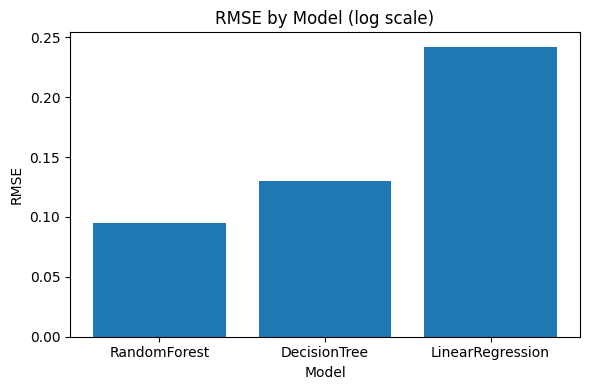

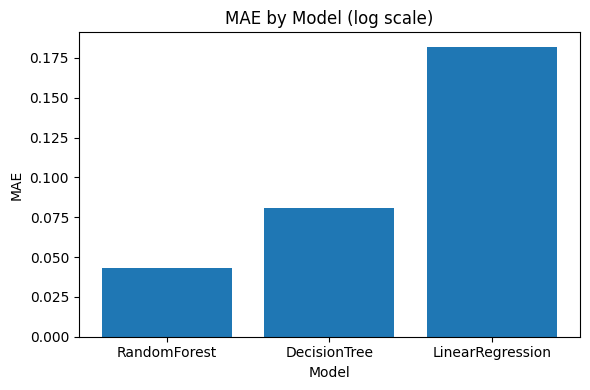

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(metrics_sorted["model"], metrics_sorted["RMSE"])
plt.title("RMSE by Model (log scale)")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(metrics_sorted["model"], metrics_sorted["MAE"])
plt.title("MAE by Model (log scale)")
plt.ylabel("MAE")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


## Results (Key Figures)
The following figures are generated by the booking pipeline.


R2 comparison


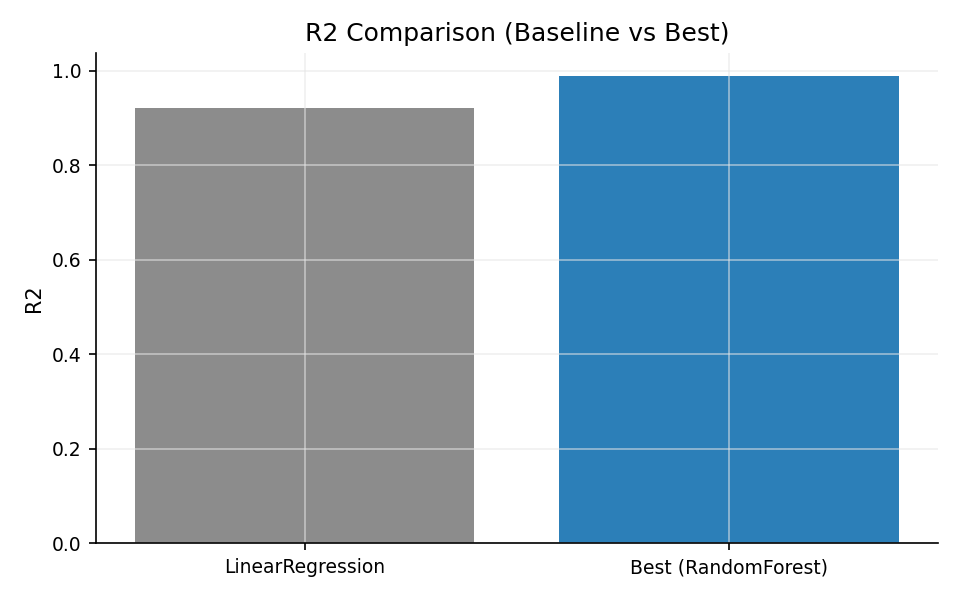

Actual vs predicted


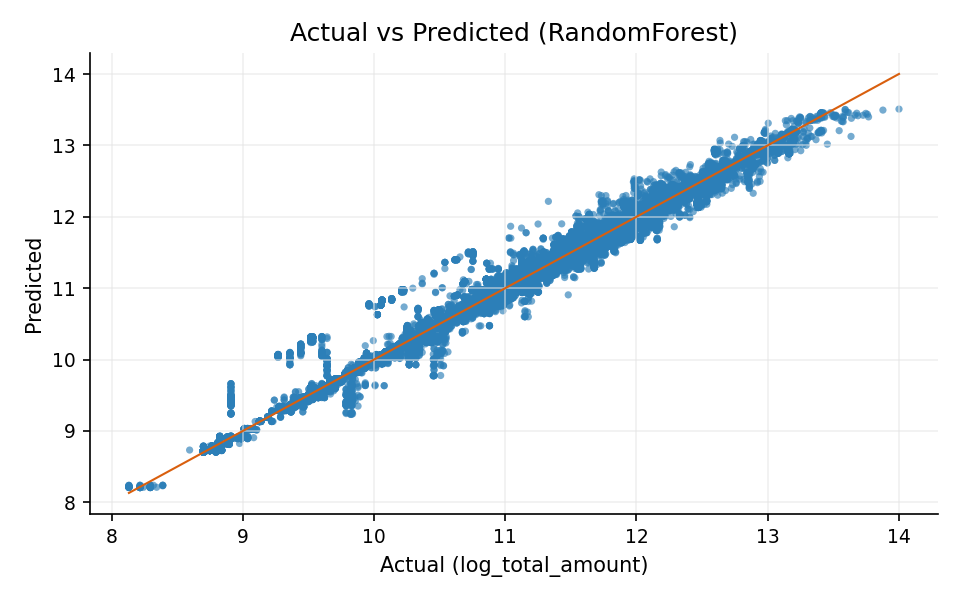

Feature importance


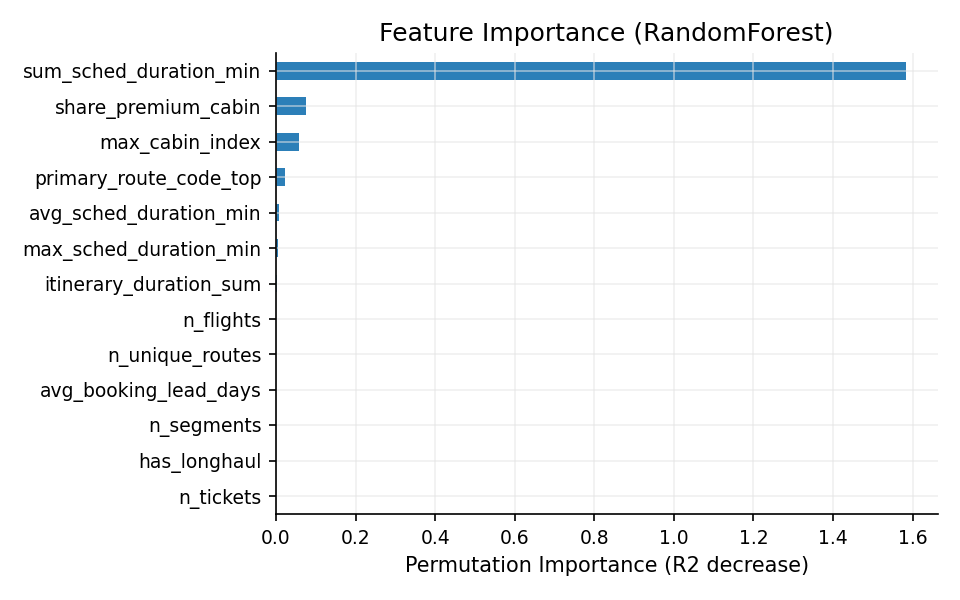

In [4]:
from IPython.display import Image, display

print("R2 comparison")
display(Image(filename=str(FIG_DIR / "r2_compare.png")))

print("Actual vs predicted")
display(Image(filename=str(FIG_DIR / "actual_vs_pred.png")))

print("Feature importance")
display(Image(filename=str(FIG_DIR / "feature_importance.png")))


## Robustness
Route hold-out split (unseen routes) is reported if metrics_robust.csv is present.


In [5]:
from IPython.display import display

if robust_path.exists():
    robust = pd.read_csv(robust_path)
    display(robust)
else:
    print("metrics_robust.csv not found; rerun pipeline to generate route hold-out results.")


,split,model,R2,RMSE,MAE,RMSE_amount,MAE_amount,MAPE_amount,target,scale,test_routes,test_rows
0,route_holdout,RandomForest,0.966,0.149,0.077,9133.645,4425.733,7.821,log_total_amount,log,91,79799


## Limitations
- Metrics are on log scale; errors for high-value bookings should be interpreted carefully.
- Limited features: no booking channel, seasonality flags, or historical yields.
- Model comparisons are baseline-level; no extensive hyperparameter tuning.


## Next Steps
- Add seasonality, channel, and route-level historical yield features.
- Try monotonic constraints or calibrated residual modeling for high-value bookings.
- Define cost-sensitive metrics aligned with business impact.
